In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [49]:
df_count = pd.read_csv("results/mobilenet/count.csv")
df_original = pd.read_csv("results/mobilenet/original.csv")
df_diff = pd.read_csv("results/mobilenet/diff.csv")

In [50]:
# fazendo a média por execução (cada época aparece num_execucoes)
df_count = df_count.groupby("epoch").mean()
df_original = df_original.groupby("epoch").mean()
df_diff = df_diff.groupby("epoch").mean()

In [51]:
# splitting training and test
df_count_train = df_count[df_count.index != -1]
df_count_test = df_count[df_count.index == -1]
df_original_train = df_original[df_original.index != -1]
df_original_test = df_original[df_original.index == -1]
df_diff_train = df_diff[df_diff.index != -1]
df_diff_test = df_diff[df_diff.index == -1]

## Frequência da ReLU

In [52]:
df_count_train["relu_proportion"] = df_count_train["zero_relu_call"] / df_count_train["total_relu_call"]

/tmp/ipykernel_6496/2529414924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_count_train["relu_proportion"] = df_count_train["zero_relu_call"] / df_count_train["total_relu_call"]


In [53]:
from model_utils import create_mobile_net
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Número de parâmetros: {count_parameters(create_mobile_net(nn.ReLU(), nn.Hardswish(), nn.Hardsigmoid(), 10, pre_trained=True, freeze=False)):_}")

Número de parâmetros: 1_528_106


In [54]:
create_mobile_net(nn.ReLU(), nn.Hardswish(), nn.Hardsigmoid(), 10, pre_trained=True, freeze=False)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1

In [55]:
relu_proportion = df_count_train["zero_relu_call"].sum() / df_count_train["total_relu_call"].sum()
print(f"Proporção Média da ReLU: {relu_proportion}    1/{round(1/relu_proportion):_}")
print(f"Total de Ponto Não Diff: {round(df_count_train['zero_relu_call'].sum()):_} / {round(df_count_train['total_relu_call'].sum()):_}")

Proporção Média da ReLU: 4.46359357696567e-08    1/22_403_473
Total de Ponto Não Diff: 2_580 / 57_792_000_000


In [56]:
sns.set_style("whitegrid", {'axes.grid' : True})

[Text(0.5, 0, 'época'), Text(0, 0.5, "relu'(0) / relu'(x)")]

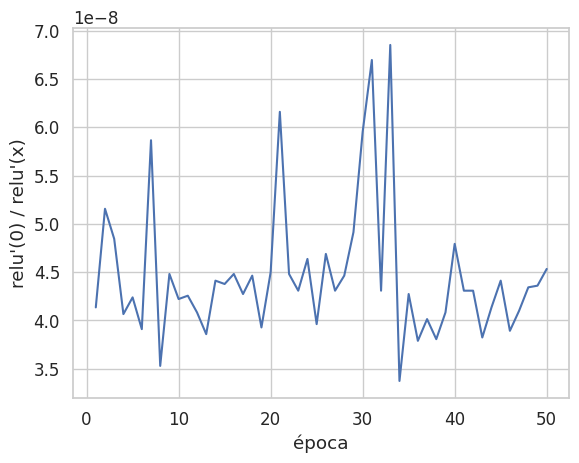

In [57]:
ax = sns.lineplot(data=df_count_train, x="epoch", y="relu_proportion")
ax.set(xlabel="época", ylabel="relu'(0) / relu'(x)")
#plt.savefig('relu_proportion.eps', format='eps')

## Comparando com funções diferenciáveis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


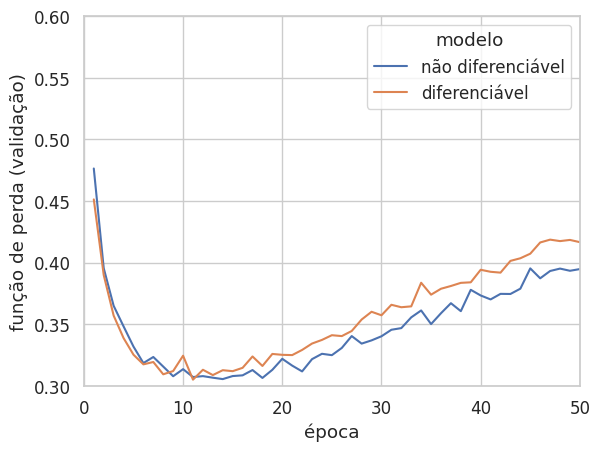

In [58]:
temp = pd.DataFrame()
temp["original"] = df_original_train["val_loss"]
temp["diff"] = df_diff_train["val_loss"]
temp["epoch"] = df_diff_train.index
temp = pd.melt(temp, ["epoch"])
temp = temp.rename(columns={"variable": "modelo"})
temp["modelo"] = temp["modelo"].replace("original", "não diferenciável")
temp["modelo"] = temp["modelo"].replace("diff", "diferenciável")
ax = sns.lineplot(data=temp, x="epoch", y="value", hue="modelo")
ax.set(xlabel="época", ylabel="função de perda (validação)")
ax.set_xlim(0, 50)
ax.set_ylim(0.3, 0.6)
plt.savefig('mobilenet_val_loss.eps', format='eps')

In [59]:
best_original = df_original_train[df_original_train["val_loss"] == df_original_train["val_loss"].min()]
best_diff = df_diff_train[df_diff_train["val_loss"] == df_diff_train["val_loss"].min()]

linhas = ["best_epoch", "test_acc", "avg_train_time", "test_time"]

data_original = [best_original.index[0]]
data_original.append(df_original_test["val_acc"].mean())
data_original.append(df_original_train["time"].mean())
data_original.append(df_original_test["time"].mean()/10000)
data_original

data_diff = [best_diff.index[0]]
data_diff.append(df_diff_test["val_acc"].mean())
data_diff.append(df_diff_train["time"].mean())
data_diff.append(df_diff_test["time"].mean()/10000)

data = {"não diff": data_original, "diff": data_diff}

df = pd.DataFrame(data=data, index=linhas)
df["diferença"] = 100 * (df["diff"] - df["não diff"]) / df["não diff"]
df

,não diff,diff,diferença
best_epoch,14.000000,11.000000,-21.428571
test_acc,0.881500,0.880480,-0.115712
avg_train_time,60.405711,57.018528,-5.607388
test_time,0.000179,0.000201,12.837277
